In [106]:
from pathlib import Path
import time
import datetime
from tqdm import tqdm
from collections import defaultdict, Counter
import copy
import random
import re
import numpy as np
import os
from sklearn.metrics import roc_auc_score
import pickle
from datetime import datetime 
import math
import uncertainty_toolbox as utc
    

In [107]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"

In [108]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

In [109]:
device = torch.device("cuda:0")

In [110]:
torch.cuda.set_device(device)

In [111]:
dataset = 'demo/'

data_path = Path("/home/v-mezhang/blob-plm/data/" + str(dataset) + "utils/")
model_path = Path("/home/v-mezhang/blob-plm/model/" + str(dataset))

date_format_str = '%m/%d/%Y %I:%M:%S %p'

# sys.stdout = open(model_path / 'output.txt', "w")
# print(model_path)
# sys.stdout.flush()

In [112]:
npratio = 4
max_his_len = 50
min_word_cnt = 3
max_title_len = 30

In [113]:
batch_size = 32
epoch = 5
lr=0.0001
name = 'nrms_' + dataset[:-1] + '_lm'
retrain = True
online_flag = False
offline_flag = False
cb_flag = False
eva_times = 2

# collect impressions

In [114]:
with open(data_path/'train_sam_uid.pkl', 'rb') as f:
    train_sam = pickle.load(f)

with open(data_path/'sorted_train_sam_uid.pkl', 'rb') as f:
    sorted_train_sam = pickle.load(f)
    
with open(data_path/'sorted_valid_sam_uid.pkl', 'rb') as f:
    valid_sam = pickle.load(f)

if os.path.exists(data_path/'test_sam_uid.pkl'):    
    with open(data_path/'test_sam_uid.pkl', 'rb') as f:
        test_sam = pickle.load(f)

In [115]:
user_count = {}
for i in valid_sam:
    poss, negs, his, uid, tsp = i
    if uid not in user_count.keys():
        user_count[uid] = 0
    else:
        user_count[uid] += 1

(array([3.392e+03, 1.068e+03, 3.190e+02, 1.320e+02, 5.000e+01, 2.100e+01,
        6.000e+00, 6.000e+00, 2.000e+00, 4.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

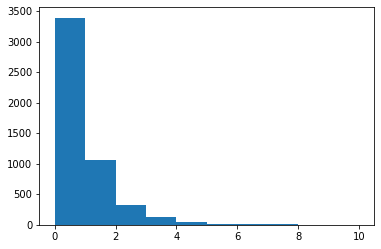

In [116]:
import matplotlib.pyplot as plt
plt.hist(list(user_count.values()))

# News Preprocess

In [117]:
with open(data_path/'nid2index.pkl', 'rb') as f:
    nid2index = pickle.load(f)
    
with open(data_path/'vocab_dict.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

# embedding_matrix = np.load(data_path/'embedding.npy')
news_index = np.load(data_path /'news_index.npy')

In [118]:
large_data_path = Path("/home/v-mezhang/blob-plm/data/large/utils/")
embedding_matrix = np.load(large_data_path/'embedding.npy')
embedding_matrix.shape

(15243, 300)

In [119]:
if os.path.exists(data_path/'test_nid2index.pkl'):
    with open(data_path/'test_nid2index.pkl', 'rb') as f:
        test_nid2index = pickle.load(f)

    test_news_index = np.load(data_path /'test_news_index.npy')
else: # TODO: for now use valid to do test (cb)
    test_nid2index = nid2index
    test_news_index = news_index
    test_sam = valid_sam

In [120]:
def cal_ctr(samples, news_click_count, news_impr_count, interval_time,):
    for l in tqdm(samples):
        pos, neg, his, uid, tsp = l
        tsp = datetime.strptime(tsp,date_format_str)
        tidx = int((tsp - start_time).total_seconds()/interval_time) 
        if type(pos) is list:
            for i in pos:
                nidx = nid2index[i]
                news_click_count[nidx, tidx] += 1
                news_impr_count[nidx, tidx] += 1
        else:
            nidx = nid2index[pos]
            news_click_count[nidx, tidx] += 1
            news_impr_count[nidx, tidx] += 1

        for i in neg:
            nidx = nid2index[i]
            news_impr_count[nidx, tidx] += 1
    return news_click_count, news_impr_count

# News Pool

In [121]:

interval_time = 3600
start_time =  datetime.strptime(sorted_train_sam[0][-1],date_format_str)
# print(start_time)
end_time = datetime.strptime(valid_sam[-1][-1],date_format_str)
nt = int((end_time - start_time).total_seconds()/interval_time) + 1 
print(len(nid2index))
print(nt)
news_click_count = np.zeros((len(nid2index), nt), dtype=float)
news_impr_count = np.ones((len(nid2index), nt), dtype=float) * 100 # assume 100 times init

news_click_count, news_impr_count = cal_ctr(train_sam, news_click_count, news_impr_count, interval_time)
news_click_count, news_impr_count = cal_ctr(valid_sam, news_click_count, news_impr_count, interval_time)

28604
168


In [122]:
# news_ctr = np.zeros_like(news_click_count)
# for i in tqdm(range(news_click_count.shape[0])):
#     for j in range(news_click_count.shape[1]):
#         if news_impr_count[i,j] == 0:
#             assert news_click_count[i,j] == 0
#             news_ctr[i,j] = 0
#         else:
#             news_ctr[i,j] = news_click_count[i,j]/news_impr_count[i,j]
news_ctr = news_click_count/news_impr_count

In [123]:
import matplotlib.pyplot as plt
# news_ctr = news_click_count/news_impr_count
# plt.imshow(news_ctr[:,166])
# plt.colorbar()
tidx = 111
nonzero = news_ctr[:,tidx][news_ctr[:, tidx] > 0]
len(nonzero)

104

(array([29., 25., 33., 19., 11.,  7., 12., 18., 10.,  4.]),
 array([ 15. ,  38.5,  62. ,  85.5, 109. , 132.5, 156. , 179.5, 203. ,
        226.5, 250. ]),
 <BarContainer object of 10 artists>)

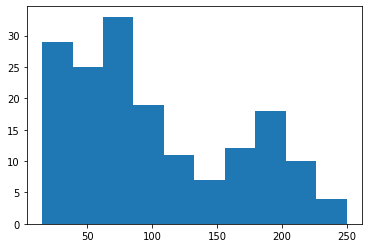

In [124]:
nonzero_count = []
for i in range(news_click_count.shape[1]):
    nonzero = news_ctr[:,i][news_ctr[:, i] > 0]
    nonzero_count.append(len(nonzero))
plt.hist(nonzero_count)

# Dataset & DataLoader

In [125]:
def newsample(nnn, ratio):
    if ratio > len(nnn):
        return nnn + ["<unk>"] * (ratio - len(nnn))
    else:
        return random.sample(nnn, ratio)

In [126]:
class TrainDataset(Dataset):
    def __init__(self, samples, nid2index, news_index):
        self.news_index = news_index
        self.nid2index = nid2index
        self.samples = samples
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # pos, neg, his, neg_his
        pos, neg, his, uid, tsp = self.samples[idx]
        neg = newsample(neg, npratio)
        
        candidate_news = [pos] + neg
        # print('pos: ', pos)
        # for n in candidate_news:
        #     print(n)
        #     print(self.nid2index[n])
        if type(candidate_news[0]) is str:
            assert candidate_news[0].startswith('N') # nid
            candidate_news = self.news_index[[self.nid2index[n] for n in candidate_news]]
        else: # nindex
            candidate_news = self.news_index[[n for n in candidate_news]]
        his = [self.nid2index[n] for n in his] + [0] * (max_his_len - len(his))
        his = self.news_index[his]
        
        label = np.array(0)
        return candidate_news, his, label

In [127]:
class NewsDataset(Dataset):
    def __init__(self, news_index):
        self.news_index = news_index
        
    def __len__(self):
        return len(self.news_index)
    
    def __getitem__(self, idx):
        return self.news_index[idx]

In [128]:
news_dataset = NewsDataset(news_index)

In [129]:
class UserDataset(Dataset):
    def __init__(self, 
                 samples,
                 news_vecs,
                 nid2index):
        self.samples = samples
        self.news_vecs = news_vecs
        self.nid2index = nid2index
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        poss, negs, his, uid, tsp = self.samples[idx]
        his = [self.nid2index[n] for n in his] + [0] * (max_his_len - len(his))
        his = self.news_vecs[his]
        return his, tsp

# NRMS

In [130]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, attn_mask=None):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k)
        scores = torch.exp(scores)
        if attn_mask is not None:
            scores = scores * attn_mask
        attn = scores / (torch.sum(scores, dim=-1, keepdim=True)  + 1e-8)
        
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model # 300
        self.n_heads = n_heads # 20
        self.d_k = d_k # 20
        self.d_v = d_v # 20
        
        self.W_Q = nn.Linear(d_model, d_k * n_heads) # 300, 400
        self.W_K = nn.Linear(d_model, d_k * n_heads) # 300, 400
        self.W_V = nn.Linear(d_model, d_v * n_heads) # 300, 400
        
        self._initialize_weights()
                
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                
    def forward(self, Q, K, V, attn_mask=None):
        residual, batch_size = Q, Q.size(0)
        
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)
        
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1).expand(batch_size, max_len, max_len) 
            attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) 
        
        context, attn = ScaledDotProductAttention(self.d_k)(q_s, k_s, v_s, attn_mask) 
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) 
        return context 

In [131]:

class AdditiveAttention(nn.Module):
    ''' AttentionPooling used to weighted aggregate news vectors
    Arg: 
        d_h: the last dimension of input
    '''
    def __init__(self, d_h, hidden_size=200):
        super(AdditiveAttention, self).__init__()
        self.att_fc1 = nn.Linear(d_h, hidden_size)
        self.att_fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x, attn_mask=None):
        """
        Args:
            x: batch_size, candidate_size, candidate_vector_dim
            attn_mask: batch_size, candidate_size
        Returns:
            (shape) batch_size, candidate_vector_dim
        """
        bz = x.shape[0]
        e = self.att_fc1(x)
        e = nn.Tanh()(e)
        alpha = self.att_fc2(e)

        alpha = torch.exp(alpha)
        if attn_mask is not None:
            alpha = alpha * attn_mask.unsqueeze(2)
        alpha = alpha / (torch.sum(alpha, dim=1, keepdim=True) + 1e-8)

        x = torch.bmm(x.permute(0, 2, 1), alpha)
        x = torch.reshape(x, (bz, -1))  # (bz, 400)
        return x

In [132]:
class TextEncoder(nn.Module):
    def __init__(self, 
                 word_embedding_dim=300, 
                 num_attention_heads=20,
                 query_vector_dim = 200,
                 dropout_rate=0.2,
                 enable_gpu=True):
        super(TextEncoder, self).__init__()
        self.dropout_rate = 0.2
        pretrained_news_word_embedding = torch.from_numpy(embedding_matrix).float()
        
        self.word_embedding = nn.Embedding.from_pretrained(
            pretrained_news_word_embedding, freeze=False)
        
        self.multihead_attention = MultiHeadAttention(word_embedding_dim,
                                              num_attention_heads, 20, 20)
        self.additive_attention = AdditiveAttention(num_attention_heads*20,
                                                    query_vector_dim)
    def forward(self, text):
        # REVIEW: remove training=self.training to enable dropout during testing 
        text_vector = F.dropout(self.word_embedding(text.long()),
                                p=self.dropout_rate,
                                # training=self.training
                                )
        multihead_text_vector = self.multihead_attention(
            text_vector, text_vector, text_vector)
        multihead_text_vector = F.dropout(multihead_text_vector,
                                          p=self.dropout_rate,
                                        #   training=self.training
                                          )
        # batch_size, word_embedding_dim
        text_vector = self.additive_attention(multihead_text_vector)
        return text_vector

In [133]:
class UserEncoder(nn.Module):
    def __init__(self,
                 news_embedding_dim=400,
                 num_attention_heads=20,
                 query_vector_dim=200
                ):
        super(UserEncoder, self).__init__()
        self.multihead_attention = MultiHeadAttention(news_embedding_dim,
                                              num_attention_heads, 20, 20)
        self.additive_attention = AdditiveAttention(num_attention_heads*20,
                                                    query_vector_dim)
        
        self.neg_multihead_attention = MultiHeadAttention(news_embedding_dim,
                                                         num_attention_heads, 20, 20)
        
    def forward(self, clicked_news_vecs):
        multi_clicked_vectors = self.multihead_attention(
            clicked_news_vecs, clicked_news_vecs, clicked_news_vecs
        )
        pos_user_vector = self.additive_attention(multi_clicked_vectors)
        
        user_vector = pos_user_vector
        return user_vector

In [134]:
class NRMS(nn.Module):
    def __init__(self):
        super(NRMS, self).__init__()
        self.text_encoder = TextEncoder()
        self.user_encoder = UserEncoder()
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, candidate_news, clicked_news, targets, compute_loss=True):
        batch_size, npratio, word_num = candidate_news.shape
        candidate_news = candidate_news.view(-1, word_num)
        candidate_vector = self.text_encoder(candidate_news).view(batch_size, npratio, -1)
        
        batch_size, clicked_news_num, word_num = clicked_news.shape
        clicked_news = clicked_news.view(-1, word_num)
        clicked_news_vecs = self.text_encoder(clicked_news).view(batch_size, clicked_news_num, -1)
        
        user_vector = self.user_encoder(clicked_news_vecs)
        
        score = torch.bmm(candidate_vector, user_vector.unsqueeze(-1)).squeeze(dim=-1)
        
        if compute_loss:
            loss = self.criterion(score, targets)
            return loss, score
        else:
            return score

# Train

In [135]:
def dcg_score(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10):
    best = dcg_score(y_true, y_true, k)
    actual = dcg_score(y_true, y_score, k)
    return actual / best


def mrr_score(y_true, y_score):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    rr_score = y_true / (np.arange(len(y_true)) + 1)
    return np.sum(rr_score) / np.sum(y_true)

In [136]:
def compute_amn(y_true, y_score):
    auc = roc_auc_score(y_true,y_score)
    mrr = mrr_score(y_true,y_score)
    ndcg5 = ndcg_score(y_true,y_score,5)
    ndcg10 = ndcg_score(y_true,y_score,10)
    return auc, mrr, ndcg5, ndcg10

def evaluation_split(news_vecs, user_vecs, samples, nid2index):
    all_rslt = []
    for i in tqdm(range(len(samples))):
        poss, negs, _, _, _ = samples[i]
        user_vec = user_vecs[i]
        y_true = [1] * len(poss) + [0] * len(negs)
        news_ids = [nid2index[i] for i in poss + negs]
        news_vec = news_vecs[news_ids]
        y_score = np.multiply(news_vec, user_vec)
        y_score = np.sum(y_score, axis=1)
        try:
            all_rslt.append(compute_amn(y_true, y_score))
        except Exception as e:
            print(e)
    return np.array(all_rslt)

In [137]:
train_ds = TrainDataset(train_sam, nid2index, news_index)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [138]:
if retrain:
    for time in range(1):
        model = NRMS().to(device)
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = nn.DataParallel(model, device_ids=[0,1,2]) 
        else:
            print('single GPU found.')
        optimizer = optim.Adam(model.parameters(), lr=lr)
        best_auc = 0
        for ep in range(epoch):
            loss = 0
            accuary = 0.0
            model.train()
            train_loader = tqdm(train_dl)
            for cnt, batch_sample in enumerate(train_loader):
                candidate_news_index, his_index, label = batch_sample
                sample_num = candidate_news_index.shape[0]
                candidate_news_index = candidate_news_index.to(device)
                his_index = his_index.to(device)
                label = label.to(device)
                bz_loss, y_hat = model(candidate_news_index, his_index, label)

                loss += bz_loss.detach().cpu().numpy()
                optimizer.zero_grad()
                bz_loss.backward()

                optimizer.step()

                if cnt % 10 == 0:
                    train_loader.set_description(f"[{cnt}]steps loss: {loss / (cnt+1):.4f} ")
                    train_loader.refresh() 


            model.eval()
            news_dl = DataLoader(news_dataset, batch_size=1024, shuffle=False, num_workers=0)
            news_vecs = []
            for news in tqdm(news_dl):
                news = news.to(device)
                news_vec = model.text_encoder(news).detach().cpu().numpy()
                news_vecs.append(news_vec)
            news_vecs = np.concatenate(news_vecs)

            user_dataset = UserDataset(valid_sam, news_vecs, nid2index)
            user_vecs = []
            user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
            for his, tsp in tqdm(user_dl):
                his = his.to(device)
                user_vec = model.user_encoder(his).detach().cpu().numpy()
                user_vecs.append(user_vec)
            user_vecs = np.concatenate(user_vecs)

            val_scores = evaluation_split(news_vecs, user_vecs, valid_sam, nid2index)
            val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*val_scores))]
            print(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}")

            with open(model_path/f'{name}.txt', 'a') as f:
                f.write(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
                    
            if val_auc > best_auc:
                best_auc = val_auc
                torch.save(model.state_dict(), model_path/f'{name}.pkl')
                with open(model_path/f'{name}.txt', 'a') as f:
                    f.write(f"[{ep}] epoch save model\n")
            

single GPU found.


[0] epoch auc: 0.5139, mrr: 0.2213, ndcg5: 0.2361, ndcg10: 0.2976


[1] epoch auc: 0.5385, mrr: 0.2287, ndcg5: 0.2410, ndcg10: 0.3066


[2] epoch auc: 0.5414, mrr: 0.2296, ndcg5: 0.2405, ndcg10: 0.3055


[3] epoch auc: 0.5420, mrr: 0.2300, ndcg5: 0.2410, ndcg10: 0.3038


[4] epoch auc: 0.5514, mrr: 0.2335, ndcg5: 0.2476, ndcg10: 0.3121


In [139]:
def print_eva_metric(y_scores, y_trues):
    all_rslt_mean = []
    all_rslt_ucb1 = []
    all_rslt_ucb05 = []
    all_rslt_ucb15 = []

    for key, value in y_scores.items():
        mean = np.asarray(value).mean(axis = 0)
        std = np.asarray(value).std(axis = 0)
        # print(utc.metrics.get_all_metrics(mean, std, np.array(y_trues[key])))
        try:
            all_rslt_mean.append(compute_amn(y_trues[key], mean))
            all_rslt_ucb1.append(compute_amn(y_trues[key], mean + std ))
            all_rslt_ucb05.append(compute_amn(y_trues[key], mean + 0.5 * std ))
            all_rslt_ucb15.append(compute_amn(y_trues[key], mean + 1.5 * std ))
        except Exception as e:
            print(e)


    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_mean)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 0 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")

    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_ucb05)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 0.5 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
        
    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_ucb1)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 1 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
   
    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_ucb15)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 1.5 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n \n")


# Offline

In [140]:
# offline 

if offline_flag:
    model = NRMS().to(device)
    model.load_state_dict(torch.load(model_path/f'{name}.pkl'))
    model.eval()
    for m in model.modules():
        if m.__class__.__name__.startswith('dropout'):
            print(m)
            m.train()

    y_scores = defaultdict(list)
    y_trues = {}

    with torch.no_grad():

        for i in tqdm(range(eva_times)):
            test_news_dataset = NewsDataset(test_news_index)
            news_dl = DataLoader(test_news_dataset, batch_size=1024, shuffle=False, num_workers=0)
            news_vecs = []
            for news in tqdm(news_dl):
                news = news.to(device)
                news_vec = model.text_encoder(news).detach().cpu().numpy()
                news_vecs.append(news_vec)
            news_vecs = np.concatenate(news_vecs)

            user_dataset = UserDataset(test_sam, news_vecs, test_nid2index)
            user_vecs = []
            user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
            for his_tsp in tqdm(user_dl):
                his, _ = his_tsp
                his = his.to(device)
                user_vec = model.user_encoder(his).detach().cpu().numpy()
                user_vecs.append(user_vec)
            user_vecs = np.concatenate(user_vecs)

            for i in tqdm(range(len(valid_sam))):
                poss, negs, _, _, _ = valid_sam[i]
                user_vec = user_vecs[i]
                y_true = [1] * len(poss) + [0] * len(negs)
                news_ids = [nid2index[i] for i in poss + negs]
                news_vec = news_vecs[news_ids]
                y_score = np.multiply(news_vec, user_vec)
                y_score = np.sum(y_score, axis=1)
                
                y_scores[i].append(y_score)
                y_trues[i] = y_true

    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"offline eva with eva : {eva_times} times\n")
    print_eva_metric(y_scores, y_trues)

    # test_auc, test_mrr, test_ndcg, test_ndcg10 = [np.mean(i) for i in list(zip(*test_scores))]
    # print(f"[{i}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}")

# with open(model_path/ f'{name}.txt', 'a') as f:
#         f.write(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}\n")

# Online

In [141]:
def construct_trainable_samples(samples):
    tr_samples = []
    for l in samples:
        pos_imp, neg_imp, his, uid, tsp = l    
        for pos in list(pos_imp):
            tr_samples.append([pos, neg_imp, his, uid, tsp])
    return tr_samples



def finetune(model, ft_sam, nid2index, news_index, batch_size):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ft_sam = construct_trainable_samples(ft_sam)
    ft_ds = TrainDataset(ft_sam, nid2index, news_index)
    ft_dl = DataLoader(ft_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    for ep in range(epoch):
        loss = 0
        accuary = 0.0
        model.train()
        ft_loader = tqdm(ft_dl)
        for cnt, batch_sample in enumerate(ft_loader):
            candidate_news_index, his_index, label = batch_sample
            sample_num = candidate_news_index.shape[0]
            candidate_news_index = candidate_news_index.to(device)
            his_index = his_index.to(device)
            label = label.to(device)
            bz_loss, y_hat = model(candidate_news_index, his_index, label)

            loss += bz_loss.detach().cpu().numpy()
            optimizer.zero_grad()
            bz_loss.backward()

            optimizer.step()

            if cnt % 10 == 0:
                ft_loader.set_description(f"[{cnt}]steps loss: {loss / (cnt+1):.4f} ")
                ft_loader.refresh() 

    return model 

def eva_batch(model, droupout_flag, batch_news_index, batch_sam, batch_nid2index, y_scores, y_trues, ucbs, batch_size, batch_id):
    model.eval()
    if droupout_flag:
        for m in model.modules():
            if m.__class__.__name__.startswith('dropout'):
                print(m)
                m.train()
    
    with torch.no_grad():
        for i in tqdm(range(eva_times)):
            batch_news_dataset = NewsDataset(batch_news_index)
            news_dl = DataLoader(batch_news_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            news_vecs = []
            for news in tqdm(news_dl):
                news = news.to(device)
                news_vec = model.text_encoder(news).detach().cpu().numpy()
                news_vecs.append(news_vec)
            news_vecs = np.concatenate(news_vecs)

            user_dataset = UserDataset(batch_sam, news_vecs, batch_nid2index)
            user_vecs = []
            user_dl = DataLoader(user_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            

            for his_tsp in tqdm(user_dl):
                his, tsp = his_tsp
                batch_time = datetime.strptime(str(tsp[-1]), date_format_str)
                his = his.to(device)
                user_vec = model.user_encoder(his).detach().cpu().numpy()
                user_vecs.append(user_vec)
                # print(tsp)
            user_vecs = np.concatenate(user_vecs)

            start_id = batch_size * batch_id

            for i in tqdm(range(len(batch_sam))):
                poss, negs, _, _,_ = batch_sam[i]
                user_vec = user_vecs[i]
                y_true = [1] * len(poss) + [0] * len(negs)
                news_ids = [nid2index[i] for i in poss + negs]
                news_vec = news_vecs[news_ids]
                y_score = np.multiply(news_vec, user_vec)
                y_score = np.sum(y_score, axis=1)
                
                y_scores[start_id+i].append(y_score)
                y_trues[start_id+i] = y_true
                
    return y_scores, y_trues, batch_time

In [142]:
# online 

if online_flag:

    print('online eva')

    model = NRMS().to(device)
    model.load_state_dict(torch.load(model_path/f'{name}.pkl'))

    y_scores = defaultdict(list)
    y_trues = {}

    update_time = None
    update_batch = 0
    batch_size = 1024
    dropout_flag = True

    n_batch = math.ceil(float(len(test_sam))/batch_size)

    for i in range(n_batch):
        upper_range = min(1024 * (i+1), len(test_sam))
        batch_sam = test_sam[1024 * i: upper_range]

        y_scores, y_trues, batch_time = eva_batch(model, dropout_flag, test_news_index, batch_sam, test_nid2index, y_scores, y_trues, batch_size, i)
        
        num_sample = len(y_scores)
        with open(model_path/f'{name}.txt', 'a') as f:
            f.write(f"online eva on batch : {i} with {num_sample} samples in current batch, up to index {upper_range}\n")
        print_eva_metric(y_scores, y_trues)
    
        if update_time is None:
            update_time = batch_time
            print('init update time: ', update_time)
        if (batch_time- update_time).total_seconds() > 3600:

            ft_sam = test_sam[1024 * update_batch: upper_range]
            if upper_range - 1024 * update_batch > 512:
                print('finetune with: '  + str(1024 * update_batch) + ' ~ ' + str(upper_range))
                model = finetune(model=model, ft_sam=ft_sam, nid2index=test_nid2index, news_index=test_news_index, batch_size=32)

                update_time = batch_time
                update_batch = i + 1
                print('update before: ', update_time)
            else: 
                print('no finetune due to insufficient samples: ', str(upper_range - 1024 * update_batch))

    torch.save(model.state_dict(), model_path/f'{name}_finetune.pkl')
# sys.stdout.close()

# Bandit Simulation

In [143]:
class CB_sim():
    def __init__(
        self, model_path, simulator_path, out_path, device,
        news_index, nid2index,
        finetune_batch_size = 32, eva_batch_size = 1024, dropout_flag = True
    ):
        self.model = NRMS().to(device)
        self.model.load_state_dict(torch.load(model_path/f'{name}.pkl'))
        
        # TODO: change simulator to PLM
        self.simulator = NRMS().to(device)
        self.simulator.load_state_dict(torch.load(simulator_path/f'{name}.pkl'))

        self.news_index = news_index
        self.nid2index = nid2index

        self.out_path = out_path
        self.dropout_flag = dropout_flag
        
        self.finetune_batch_size = finetune_batch_size
        self.eva_batch_size = eva_batch_size
        self.date_format_str = '%m/%d/%Y %I:%M:%S %p'

    
    def enable_dropout(self):
        for m in self.model.modules():
            if m.__class__.__name__.startswith('dropout'):
                print(m)
                m.train() 
        
    def get_news_vec(self, model, batch_news_index):
        batch_news_dataset = NewsDataset(batch_news_index)
        news_dl = DataLoader(batch_news_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        news_vecs = []
        for news in tqdm(news_dl):
            news = news.to(device)
            news_vec = model.text_encoder(news).detach().cpu().numpy()
            news_vecs.append(news_vec)
        news_vecs = np.concatenate(news_vecs)

        return news_vecs

    def get_user_vec(self, model, batch_sam, news_vecs, batch_nid2index):
        user_dataset = UserDataset(batch_sam, news_vecs, batch_nid2index)
        user_vecs = []
        user_dl = DataLoader(user_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        for his_tsp in tqdm(user_dl):
            his, tsp = his_tsp
            his = his.to(device)
            user_vec = model.user_encoder(his).detach().cpu().numpy()
            user_vecs.append(user_vec)
            # print(tsp)
        user_vecs = np.concatenate(user_vecs)

        return user_vecs
        
    def get_cand_news(self, t, poss, negs, m = 10):
        """
        Generate candidates news based on CTR.

        t: string, impr time
        poss: list, positive samples in impr
        negs: list, neg samples in impr
        m: int, number of candidate news to return

        Return: array, candidate news id 
        """
        t = datetime.strptime(t,date_format_str)
        tidx = int((t - start_time).total_seconds()/interval_time)

        nonzero = news_ctr[:,tidx -1][news_ctr[:, tidx-1] > 0]
        nonzero_idx = np.where(news_ctr[:, tidx-1] > 0)[0]
        # print(nonzero_idx)

        nonzero = nonzero/nonzero.sum()
        assert (nonzero.sum() - 1) < 1e-3
        # print(np.sort(nonzero)[-5:])

        # sampling according to normalised ctr in last one hour
        sample_nids = np.random.choice(nonzero_idx, size = m, replace = False, p = nonzero)
        # REVIEW: check whether the sampled nids are reasonable
        
        # print(news_ctr[sample_nidx, tidx-1])
        # plt.hist(nonzero)
        # print(poss)
        # print(negs)
        poss_nids = np.array([self.nid2index[n] for n in poss])
        negs_nids = np.array([self.nid2index[n] for n in negs])
        # print('get cand news')
        # print(sample_nids)
        # print(poss_nids)
        # print(negs_nids)

        return np.concatenate([sample_nids, poss_nids, negs_nids])
        
#     t =  sorted_train_sam[1500][-1]
#     gene_news_pool(t, 20)

    def construct_trainable_samples(self, samples):
        tr_samples = []
        for l in samples:
            pos_imp, neg_imp, his, uid, tsp = l    
            for pos in list(pos_imp):
                tr_samples.append([pos, neg_imp, his, uid, tsp])
        return tr_samples

    def finetune(self, ft_sam):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        ft_sam = self.construct_trainable_samples(ft_sam)
        ft_ds = TrainDataset(ft_sam, self.nid2index, self.news_index)
        ft_dl = DataLoader(ft_ds, batch_size=self.finetune_batch_size, shuffle=True, num_workers=0)
        for ep in range(epoch):
            loss = 0
            accuary = 0.0
            self.model.train()
            ft_loader = tqdm(ft_dl)
            for cnt, batch_sample in enumerate(ft_loader):
                candidate_news_index, his_index, label = batch_sample
                sample_num = candidate_news_index.shape[0]
                candidate_news_index = candidate_news_index.to(device)
                his_index = his_index.to(device)
                label = label.to(device)
                bz_loss, y_hat = self.model(candidate_news_index, his_index, label)

                loss += bz_loss.detach().cpu().numpy()
                optimizer.zero_grad()
                bz_loss.backward()

                optimizer.step()

                if cnt % 10 == 0:
                    ft_loader.set_description(f"[{cnt}]steps loss: {loss / (cnt+1):.4f} ")
                    ft_loader.refresh() 

    def get_ucb_score(self, exper_id, y_score, t):
        ucb = []
        beta_t = 1

        mean = np.asarray(y_score).mean(axis = 0)
        std = np.asarray(y_score).std(axis = 0)
        ucb_score = mean + beta_t * std

        rec_nids = np.argsort(ucb_score)[-k:]
        return rec_nids

    def epsilon_greedy(self, exper_id, y_score, k):
        rec = []
        y_score = y_score[0]
        p = np.random.rand(k)
        n_greedy = int(len(p[p > self.policy_para]))
        greedy_nids = np.argsort(y_score)[-n_greedy:]
        eps_nids = np.random.choice(np.array(list(set(range(len(y_score))) - set(greedy_nids))), size = k - n_greedy, replace=False)
        rec_nids= np.concatenate([greedy_nids, eps_nids])
        return rec_nids
        
    def sigmoid(self, x):
        return np.array([1/(1 + math.exp(-i)) for i in x])
                
    def rec(self, batch_sam, batch_id, exper_id, k = 8):
        """
        Simulate recommendations
        """
        if self.policy == 'epsilon_greedy':
            self.n_inference = 1
        
        self.model.eval()
        if self.dropout_flag:
            self.enable_dropout()

        y_scores = defaultdict(list) # key: sam_id, value: list of n_inference scores 
        cand_nids_dict = {} # key: sam_id, value: array of candidate news ids
        start_id = self.eva_batch_size * batch_id

        with torch.no_grad():
            sim_news_vecs = self.get_news_vec(self.simulator, self.news_index)
            sim_user_vecs = self.get_user_vec(self.simulator, batch_sam, sim_news_vecs, self.nid2index) 

            # generate scores with uncertainty (dropout during inference)
            for _ in tqdm(range(self.n_inference)):
                # TODO: speed up - only pass batch news index
                news_vecs = self.get_news_vec(self.model, self.news_index)
                user_vecs = self.get_user_vec(self.model, batch_sam, news_vecs, self.nid2index)
                
                for i in range(len(batch_sam)):
                    t = start_id + i
                    poss, negs, his, uid, tsq = batch_sam[i]     
                    user_vec = user_vecs[i]
                    
                    if t not in cand_nids_dict.keys():
                        # cand set (is a randomised set) keeps same for inference times
                        cand_nids = self.get_cand_news(tsq, poss, negs)
                        cand_nids_dict[t] = cand_nids
                        # print(cand_nids)
                        news_vec = news_vecs[cand_nids]
                        sim_user_vec = sim_user_vecs[i]
                        sim_news_vec = sim_news_vecs[cand_nids]
                        sim_y_score = np.sum(np.multiply(sim_news_vec, sim_user_vec), axis=1)
                        # assume the user would at most click half of the recommended news
                        opt_nids = np.argsort(sim_y_score)[-int(k/2):] 
                        # print(opt_nids)
                        # print(self.sigmoid(sim_y_score[opt_nids]))
                        opt_nids = opt_nids[self.sigmoid(sim_y_score[opt_nids]) > 0.5]
                        # print(opt_nids)
                        self.opts[exper_id].append(opt_nids)   
                    
                    news_vec = news_vecs[cand_nids_dict[t]]
                    y_score = np.sum(np.multiply(news_vec, user_vec), axis=1)
                    y_scores[t].append(y_score)

        # generate recommendations and calculate rewards
        for i in range(len(batch_sam)):
            t = start_id + i
            _, _, his, uid, tsq = batch_sam[i]  

            if self.policy == 'ucb':
                rec_nids = self.get_ucb_score(exper_id, y_scores[t], t)
            elif self.policy == 'epsilon_greedy':
                rec_nids = self.epsilon_greedy(exper_id, y_scores[t], k)
            else:
                raise NotImplementedError

            self.recs[exper_id].append(rec_nids) 
            
            opt_nids = self.opts[exper_id][i]
 
            assert len(set(rec_nids)) == k
            # assert len(set(opt_nids)) == k

            reward = len(set(rec_nids) & set(opt_nids)) # reward as the overlap between rec and opt set
            # self.cumu_reward += reward
            self.rewards[exper_id, t] = reward
            self.opt_rewards[exper_id, t] = len(set(opt_nids))

            rec_poss = [rec_nid for rec_nid in rec_nids if rec_nid in opt_nids]
            # let all 
            rec_negs = list(set(cand_nids_dict[t]) - set(rec_poss))
            
            self.rec_sam.append([rec_poss, rec_negs, his, uid, tsq])
        
    def run_exper(self, test_sam, num_exper = 10, n_inference = 2, policy = 'ucb', policy_para = 0.1):
        
        num_sam = len(test_sam)
        n_batch = math.ceil(float(num_sam)/self.eva_batch_size)
        self.rec_sam = []
        self.rewards = np.zeros((num_exper, num_sam))
        self.opt_rewards = np.zeros((num_exper, num_sam))
        self.recs = defaultdict(list)
        self.opts = defaultdict(list)

        self.n_inference = n_inference
        self.policy = policy
        self.policy_para = policy_para

        update_time = None
        update_batch = 0
        

        for j in range(num_exper):
            # self.cumu_reward = 0
            
            for i in range(n_batch):
                upper_range = min(self.eva_batch_size * (i+1), len(test_sam))
                batch_sam = test_sam[self.eva_batch_size * i: upper_range]

                self.rec(batch_sam, i, j)

                if update_time is None:
                    update_time = datetime.strptime(str(batch_sam[0][-1]), self.date_format_str)
                    print('init time: ', update_time)

                batch_time = datetime.strptime(str(batch_sam[-1][-1]), self.date_format_str)
                if (batch_time- update_time).total_seconds() > 3600:
                    lower_range = self.eva_batch_size * update_batch
                    ft_sam = self.rec_sam[lower_range: upper_range]
                    if upper_range - lower_range > 512:
                        print('finetune with: '  + str(lower_range) + ' ~ ' + str(upper_range))
                        self.finetune(ft_sam=ft_sam)

                        update_time = batch_time
                        update_batch = i + 1
                        print('update at: ', update_time)
                    else: 
                        print('no finetune due to insufficient samples: ', str(upper_range - lower_range))

        self.save_results()

    def save_results(self):
        policy_name = self.policy + '_' + str(self.policy_para)
        torch.save(self.model.state_dict(), os.path.join(model_path, (policy_name + f'_{name}_finetune.pkl')))
        with open(os.path.join(self.out_path, (policy_name + "_recs.pkl")), "wb") as f:
            pickle.dump(self.recs, f)
        with open(os.path.join(self.out_path, (policy_name + "_opts.pkl")), "wb") as f:
            pickle.dump(self.opts, f)
        with open(os.path.join(self.out_path, (policy_name + "_rewards.pkl")), "wb") as f:
            pickle.dump(self.rewards, f)
        with open(os.path.join(self.out_path, (policy_name+ "_opt_rewards.pkl")), "wb") as f:
            pickle.dump(self.opt_rewards, f)
        


In [144]:
if cb_flag:
    for para in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
        print(para)
        cb_sim = CB_sim(model_path=model_path, simulator_path=model_path, out_path=model_path, device=device, news_index=test_news_index, nid2index=test_nid2index)
        cb_sim.run_exper(test_sam=test_sam, num_exper=2, n_inference = 2, policy='epsilon_greedy', policy_para=para)